In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import (
    chi2_contingency, 
    f_oneway, 
    kruskal, 
    pointbiserialr,
    pearsonr,
    spearmanr
)
from scipy.stats import spearmanr, pearsonr, kendalltau, chi2_contingency
from pandas.api.types import is_numeric_dtype
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score, mean_absolute_error


In [2]:
path=r'/Users/sofiiamanko/autoformula/cirrhosis.csv'
df = pd.read_csv(path)
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


## Preliminary data sanitization.

In [3]:
def preprocess_dataset(
    df: pd.DataFrame,
    target: str | None = None,
    sample_rows: int | None = None,
    stratify: bool = True,
    random_state: int = 42
) -> pd.DataFrame:


    '''Performs three checks:
      1. Detects and removes duplicate rows.
      2. Detects and removes duplicate columns.
      3. (Optional) Performs stratified sampling if `sample_rows` is specified.
      
      Parameters
      ----------
      df : Input dataset to be preprocessed.

      target : str or None, optional (default=None)
        Name of the target column used for stratified sampling. If None, random sampling is applied.

      sample_rows : int or None, optional (default=None)
        Number of rows to sample from the dataset. If None or greater than dataset size, no sampling is performed.

      stratify : bool, optional (default=True)
        Whether to preserve class proportions in the target variable when sampling. Only applies if `target` is provided and has more than one unique value.
      
      random_state : int, optional (default=42)
        Random seed for reproducible sampling.

        
      '''
    

    print(f"Initial dataset shape: {df.shape}")

  # duplicate rows
    dup_rows = df.duplicated().sum()

    if dup_rows > 0:
        print(f"Found {dup_rows} duplicate rows - removing them.")
        df = df.drop_duplicates()
    else:
        print("No duplicate rows found.")

  # duplicate columns
    dup_cols = df.T.duplicated().sum()

    if dup_cols > 0:
        print(f"Found {dup_cols} duplicate columns — removing them.")
        df = df.loc[:, ~df.T.duplicated()]
    else:
        print("No duplicate columns found.")

    # stratified sampling

    if sample_rows is not None and sample_rows < len(df):

        if target is not None and stratify and df[target].nunique() > 1:

            df_sampled, _ = train_test_split(
                df,
                train_size=sample_rows,
                stratify=df[target],
                random_state=random_state
            )
        else:
            
            df_sampled = df.sample(n=sample_rows, random_state=random_state)

        df = df_sampled.reset_index(drop=True)
    else:
      print("Sampling not applied (using full dataset).")


    print(f"Dataset shape after sanitization: {df.shape}")

    return df

In [4]:
df_clean1 = preprocess_dataset(df, target="Status", sample_rows=None)
df_clean1

Initial dataset shape: (418, 20)
No duplicate rows found.
No duplicate columns found.
Sampling not applied (using full dataset).
Dataset shape after sanitization: (418, 20)


,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,D,NaN,24472,F,NaN,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,415,1103,C,NaN,14245,F,NaN,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,416,1055,C,NaN,20819,F,NaN,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,417,691,C,NaN,21185,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0


In [5]:
df_clean2 = preprocess_dataset(df, target="Status", sample_rows=150, stratify=True)

Initial dataset shape: (418, 20)
No duplicate rows found.
No duplicate columns found.
Dataset shape after sanitization: (150, 20)


In [6]:
def detect_feature_types(df: pd.DataFrame, min_success: float = 0.9, detect_mixed: bool = False) -> pd.DataFrame:

    '''
    Detects broad semantic type of each column:
        - numeric - integers / floats or string columns mostly convertible to numbers (default min_success=0.9)
        - categorical - discrete values with low unique count
        - datetime - pandas datetime dtype
        - bool - boolean dtype or simple Y/N, 0/1 encodings
        - text - high-cardinality free text

    Parameters
    ----------
    df : Input dataset for feature type detection (can be used cleaned df = output of preprocess_dataset() function )
    
    min_success : float, optional (default=0.9)
        Minimum proportion of successfully converted values (for string-to-numeric casting) required to treat an object
        column as numeric.

    detect_mixed : bool, optional (default=False)
        If True, flags columns that contain a mix of numeric-looking and text values.

    Returns
    -------
    pd.DataFrame
        A summary df with the following columns:
        - 'column' : column name
        - 'pandas_dtype' : technical dtype from pandas
        - 'detected_type' : inferred semantic type

    '''
    
    def find_mixed_type_columns(df):
        """Returns a list of column names where 10–90% of entries look numeric."""
        mixed = []
        for col in df.columns:
            s = df[col].dropna().astype(str)
            is_num = (
                s
                .str.replace('.', '', 1, regex=False)
                .str.replace('-', '', 1, regex=False)
                .str.isnumeric()
            )
            num_frac = is_num.mean()
            if 0.1 < num_frac < 0.9:
                mixed.append(col)
        return mixed
    

    records = []

    for col in df.columns:
        s = df[col]
        pd_dtype = str(s.dtype)
        detected = None

        if pd.api.types.is_datetime64_any_dtype(s):
            detected = "datetime"

        elif pd.api.types.is_bool_dtype(s):
            detected = "bool"

        else:
            if pd.api.types.is_object_dtype(s):
                vals = s.dropna().astype(str).str.lower().unique()
                if len(vals) <= 2 and set(vals).issubset({"y", "n", "yes", "no", "true", "false", "1", "0"}):
                    detected = "bool"

            if detected is None and pd.api.types.is_numeric_dtype(s):
                detected = "numeric"
            
            elif detected is None and s.dtype == "object":

                s_num = pd.to_numeric(s, errors="coerce")
                success = s_num.notna().mean()
                if success >= min_success:
                    detected = "numeric"

            if detected is None:
                s_str = s.dropna().astype(str)
                n_unique = s_str.nunique()
                n_total = len(s_str)
                unique_ratio = n_unique / max(1, n_total)
                avg_len = s_str.map(len).mean()
                
                p = s_str.value_counts(normalize=True)
                entropy = -np.sum(p * np.log2(p)) if len(p) > 0 else 0

                if (
                    n_unique < 30
                    or (unique_ratio < 0.05 and avg_len < 10 and entropy < np.log2(50))
                ):
                    detected = "categorical"
                else:
                    detected = "text"


        
    
        records.append({
            "column": col,
            "pandas_dtype": pd_dtype,
            "detected_type": detected
        })

    result = pd.DataFrame(records)

    # Optional: mark mixed
    if detect_mixed:
        mixed_cols = find_mixed_type_columns(df)
        result["mixed_type"] = result["column"].isin(mixed_cols)

    return result


In [7]:
df_types = detect_feature_types(df_clean1, detect_mixed= True)
df_types

,column,pandas_dtype,detected_type,mixed_type
0,ID,int64,numeric,False
1,N_Days,int64,numeric,False
2,Status,object,categorical,False
3,Drug,object,categorical,False
4,Age,int64,numeric,False
5,Sex,object,categorical,False
6,Ascites,object,bool,False
7,Hepatomegaly,object,bool,False
8,Spiders,object,bool,False
9,Edema,object,categorical,False


In [8]:
cols=['Status', 'Drug', 'Sex', 'Edema']
for col in cols:
    print(df_clean1[col].value_counts(dropna=False))

Status
C     232
D     161
CL     25
Name: count, dtype: int64
Drug
D-penicillamine    158
Placebo            154
NaN                106
Name: count, dtype: int64
Sex
F    374
M     44
Name: count, dtype: int64
Edema
N    354
S     44
Y     20
Name: count, dtype: int64


In [9]:
def type_mismatch(types_df):
    '''
    Identifies columns where the pandas dtype doesnt match the detected semantic type.
    
    Parameters
    ----------
    types_df : pd.DataFrame
        Output DataFrame from detect_feature_types(), containing columns:
        ['column', 'pandas_dtype', 'detected_type']

    If detect_mixed=True was used, the df may also include a 'mixed_type' column.
    '''

    required_cols = {"pandas_dtype", "detected_type"}

    if not required_cols.issubset(types_df.columns):

        raise ValueError(f"types_df must contain {required_cols}")

    mismatched = types_df[

        (types_df["pandas_dtype"].str.contains("object") & (types_df["detected_type"] != "text"))
        | ((types_df["pandas_dtype"].str.contains("float|int")) & (types_df["detected_type"] == "categorical"))
        
    ]

    display_cols = ["column", "pandas_dtype", "detected_type"]
    if "mixed_type" in types_df.columns:
        display_cols.append("mixed_type")

    return mismatched[display_cols]


In [10]:
df_mismatch=type_mismatch(df_types)
df_mismatch

,column,pandas_dtype,detected_type,mixed_type
2,Status,object,categorical,False
3,Drug,object,categorical,False
5,Sex,object,categorical,False
6,Ascites,object,bool,False
7,Hepatomegaly,object,bool,False
8,Spiders,object,bool,False
9,Edema,object,categorical,False


In [11]:
def handle_selected_columns(
    df: pd.DataFrame,
    types_df: pd.DataFrame,
    selected: list[str],
    numeric_threshold: float = 0.6
) -> pd.DataFrame:
    """
    Safely converts only selected columns to their detected semantic types.

    Parameters
    ----------
    df : Input dataset for feature type detection (can be used cleaned df = output of preprocess_dataset() function).
    
    types_df : pd.DataFrame
        Output of detect_feature_types(), may include 'mixed_type' flag.
    
    selected : list[str]
        Columns chosen by the user for conversion.

    numeric_threshold : float, optional (default=0.6)
        Threshold for deciding whether a mixed-type column should be treated as numeric.
    
    """

    df_out = df.copy()

    type_map = types_df.set_index("column")["detected_type"].to_dict()
    mixed_map = types_df.set_index("column")["mixed_type"].to_dict() if "mixed_type" in types_df.columns else {}

    for col in selected:

        if col not in df_out.columns:

            print(f"Column '{col}' not found, skipping.")
            continue

        target_type = type_map.get(col)
        is_mixed = mixed_map.get(col, False)

        # handle mixed-type columns 
        if is_mixed:
            s = df_out[col].dropna().astype(str)
            is_num = (
                s
                .str.replace('.', '', 1, regex=False)
                .str.replace('-', '', 1, regex=False)
                .str.isnumeric()
            )
            num_frac = is_num.mean()

            if num_frac > numeric_threshold:
                df_out[col] = pd.to_numeric(df_out[col], errors="coerce")
                print(f"'{col}' marked as mixed-type - converted to numeric (≈{num_frac:.0%} numeric).")
            else:
                df_out[col] = df_out[col].astype("category")
                print(f"'{col}' marked as mixed-type - converted to categorical (≈{num_frac:.0%} numeric).")
            continue  

        # normal conversion flow 
        try:
            if target_type == "bool":
                df_out[col] = (
                    df_out[col].astype(str).str.lower()
                    .map({"y": True, "yes": True, "1": True, "n": False, "no": False, "0": False})
                    .astype("boolean")
                )
                print(f"Converted '{col}' to boolean.")

            elif target_type == "categorical":
                df_out[col] = df_out[col].astype("category")
                print(f"Converted '{col}' to category.")

            elif target_type == "numeric":
                df_out[col] = pd.to_numeric(df_out[col], errors="coerce")
                print(f"Converted '{col}' to numeric.")

            else:
                print(f"Skipping '{col}' ({target_type}) — not a convertible type.")

        except Exception as e:
            print(f"Error converting '{col}': {e}")

    return df_out


In [12]:
selected = ["Ascites", "Hepatomegaly", "Spiders", "Sex", "Drug", 'Status', 'Edema']
df_out=handle_selected_columns(df_clean1, df_types, selected)

Converted 'Ascites' to boolean.
Converted 'Hepatomegaly' to boolean.
Converted 'Spiders' to boolean.
Converted 'Sex' to category.
Converted 'Drug' to category.
Converted 'Status' to category.
Converted 'Edema' to category.


In [13]:
df_out.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,True,True,True,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,False,True,True,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,False,False,False,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,False,True,True,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,False,True,True,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [14]:
df_out.dtypes

ID                  int64
N_Days              int64
Status           category
Drug             category
Age                 int64
Sex              category
Ascites           boolean
Hepatomegaly      boolean
Spiders           boolean
Edema            category
Bilirubin         float64
Cholesterol       float64
Albumin           float64
Copper            float64
Alk_Phos          float64
SGOT              float64
Tryglicerides     float64
Platelets         float64
Prothrombin       float64
Stage             float64
dtype: object

In [15]:
def feature_summary(df: pd.DataFrame) -> pd.DataFrame:
    
    '''
    Returns a DataFrame indexed by feature names with summary statistics.
    
    Parameters
    ----------
    df: Input dataset for feature summery (can be used df_out = output of handle_selected_columns() function).

    Returns
    -------
    pd.DataFrame
        Summary df with:
        - dtype : pandas data type of the feature
        - n_unique : number of unique non-null values
        - missing_rate : fraction of missing values
        - is_constant : True if all values are identical
        - dominant_ratio : share of the most frequent value
        - dominant_value : the most frequent value itself
    
    '''

    if df.empty:
        return pd.DataFrame(columns=["n_unique", "missing_rate", "is_constant", "dominant_ratio", "dominant_value"])

    n_rows = len(df)
    rows = []

    for col in df.columns:
        series = df[col]
        counts = series.value_counts(dropna=True)

        n_unique = series.nunique(dropna=True)
        missing_rate = round(series.isna().mean(), 4)
        dominant_value = counts.idxmax() if not counts.empty else None
        dominant_ratio = round(counts.max() / n_rows, 4) if not counts.empty else None

        rows.append({
            "feature": col,
            "dtype": str(series.dtype),
            "n_unique": n_unique,
            "missing_rate": missing_rate,
            "is_constant": (n_unique == 1),
            "dominant_ratio": dominant_ratio,
            "dominant_value": dominant_value
        })

    return pd.DataFrame(rows).set_index("feature")


In [16]:
feature_summary(df_out)


,dtype,n_unique,missing_rate,is_constant,dominant_ratio,dominant_value
feature,,,,,,
ID,int64,418,0.0000,False,0.0024,1
N_Days,int64,399,0.0000,False,0.0048,1434
Status,category,3,0.0000,False,0.5550,C
Drug,category,2,0.2536,False,0.3780,D-penicillamine
Age,int64,344,0.0000,False,0.0167,19724
Sex,category,2,0.0000,False,0.8947,F
Ascites,boolean,2,0.2536,False,0.6890,False
Hepatomegaly,boolean,2,0.2536,False,0.3828,True
Spiders,boolean,2,0.2536,False,0.5311,False


In [17]:
def fill_missing_safe(df: pd.DataFrame, types_df: pd.DataFrame) -> pd.DataFrame:
    """
    Replaces missing values with type-appropriate null representations.

    Purpose:
      Ensures consistent null types across features:
        - numeric - np.nan
        - categorical - pd.NA
        - text - pd.NA
        - bool - pd.NA
        - datetime - pd.NaT

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset (e.g. cleaned df_out after handle_selected_columns()).
    types_df : pd.DataFrame
        Output of detect_feature_types(), containing ['column', 'detected_type'].

    Returns
    -------
    pd.DataFrame
        Copy of the dataset with consistent nulls according to feature type.
    """

    df_correct = df.copy()
    type_map = types_df.set_index("column")["detected_type"].to_dict()

    for col, detected_type in type_map.items():
        if col not in df_correct.columns:
            continue

        if detected_type == "numeric":
            df_correct[col] = df_correct[col].replace({None: np.nan})

        elif detected_type in ("categorical", "text", "bool"):
            df_correct[col] = df_correct[col].replace({None: pd.NA, np.nan: pd.NA})

        elif detected_type == "datetime":
            df_correct[col] = df_correct[col].replace({None: pd.NaT, np.nan: pd.NaT})

    return df_correct


In [18]:
df_types1 = detect_feature_types(df_out)
df_types1

,column,pandas_dtype,detected_type
0,ID,int64,numeric
1,N_Days,int64,numeric
2,Status,category,categorical
3,Drug,category,categorical
4,Age,int64,numeric
5,Sex,category,categorical
6,Ascites,boolean,bool
7,Hepatomegaly,boolean,bool
8,Spiders,boolean,bool
9,Edema,category,categorical


In [19]:
df_correct=fill_missing_safe(df_out, df_types)
df_correct

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,True,True,True,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,False,True,True,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,False,False,False,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,False,True,True,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,False,True,True,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,D,NaN,24472,F,<NA>,<NA>,<NA>,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,415,1103,C,NaN,14245,F,<NA>,<NA>,<NA>,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,416,1055,C,NaN,20819,F,<NA>,<NA>,<NA>,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,417,691,C,NaN,21185,F,<NA>,<NA>,<NA>,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0


In [20]:
def split_by_feature_type(df: pd.DataFrame, types_df: pd.DataFrame):
    """
    Splits the dataset into subsets by detected feature types:
      - numeric + bool
      - categorical
      - text
      - datetime

    Parameters
    ----------
    df : pd.DataFrame
        The cleaned dataset (for example, output of handle_selected_columns() or fill_missing_safe()).

    types_df : pd.DataFrame
        Output of detect_feature_types(), containing columns:
        ['column', 'detected_type'].

    Returns
    -------
    dict of pd.DataFrame
        {
            "numeric_bool": df_numeric_bool,
            "categorical": df_category,
            "text": df_text,
            "datetime": df_datetime
        }
    """

    type_map = types_df.set_index("column")["detected_type"].to_dict()

    numeric_bool_cols = [col for col, t in type_map.items() if t in {"numeric", "bool"} and col in df.columns]
    categorical_cols  = [col for col, t in type_map.items() if t == "categorical" and col in df.columns]
    text_cols         = [col for col, t in type_map.items() if t == "text" and col in df.columns]
    datetime_cols     = [col for col, t in type_map.items() if t == "datetime" and col in df.columns]

    dfs = {
        "numeric_bool": df[numeric_bool_cols].copy(),
        "categorical": df[categorical_cols].copy(),
        "text": df[text_cols].copy(),
        "datetime": df[datetime_cols].copy()
    }

    print(f"Split complete:")
    print(f"numeric/bool: {len(numeric_bool_cols)} cols")
    print(f"categorical: {len(categorical_cols)} cols")
    print(f"text: {len(text_cols)} cols")
    print(f"datetime: {len(datetime_cols)} cols")

    return dfs

In [21]:
dfs = split_by_feature_type(df, df_types1)
df_num = dfs["numeric_bool"]
df_cat = dfs["categorical"]
df_text = dfs["text"]
df_dt = dfs["datetime"]


Split complete:
numeric/bool: 16 cols
categorical: 4 cols
text: 0 cols
datetime: 0 cols


In [22]:
def check_correlations(df_num):
    '''
    Compute Pearson, Spearman, and Kendall correlation matrices for numeric columns in a df.
    
    Parameters
    ----------
    df_num: pd.DataFrame
        Initial dataset (or output of split_by_feature_type())                                                     
    '''

    numeric_df = df_num.select_dtypes(include=["float64", "int64", "bool"])

    pearson_corr = numeric_df.corr(method="pearson")
    spearman_corr = numeric_df.corr(method="spearman")
    kendall_corr = numeric_df.corr(method="kendall")

    print("Pearson:\n", pearson_corr.head())
    print("\nSpearman:\n", spearman_corr.head())
    print("\nKendall:\n", kendall_corr.head())

    return {
        "pearson": pearson_corr,
        "spearman": spearman_corr,
        "kendall": kendall_corr
    }



In [24]:
correlations = check_correlations(df_num)

Pearson:
                    ID    N_Days       Age  Bilirubin  Cholesterol   Albumin  \
ID           1.000000 -0.354305  0.037136  -0.062154     0.032897 -0.128924   
N_Days      -0.354305  1.000000 -0.125934  -0.403953    -0.138236  0.430829   
Age          0.037136 -0.125934  1.000000   0.002362    -0.157620 -0.182350   
Bilirubin   -0.062154 -0.403953  0.002362   1.000000     0.397129 -0.314177   
Cholesterol  0.032897 -0.138236 -0.157620   0.397129     1.000000 -0.069733   

               Copper  Alk_Phos      SGOT  Tryglicerides  Platelets  \
ID          -0.098663 -0.352856 -0.012097      -0.034100  -0.076699   
N_Days      -0.364809  0.149269 -0.225492      -0.153000   0.151361   
Age          0.061549 -0.047247 -0.149869       0.022065  -0.148201   
Bilirubin    0.456918  0.116984  0.441730       0.436748  -0.013435   
Cholesterol  0.126115  0.149473  0.353246       0.276830   0.191710   

             Prothrombin     Stage  
ID             -0.191930 -0.033757  
N_Days        

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
from scipy.stats import chi2_contingency

In [26]:
def plot_correlation_heatmaps(corrs_dict, figsize=(30, 10), annot_size=12):
    '''
    Plot correlation heatmaps from the dict returned by check_correlations().

    Parameters
    ----------
    corrs_dict : dict
        Dictionary with correlation matrices:
        {
            "pearson": pd.DataFrame,
            "spearman": pd.DataFrame,
            "kendall": pd.DataFrame
        }

    figsize : tuple, optional
        Size of the figure (default=(30, 10)).

    annot_size : int, optional
        Font size for correlation values (default=12).
    '''

    pearson_corr = corrs_dict.get("pearson")
    spearman_corr = corrs_dict.get("spearman")
    kendall_corr = corrs_dict.get("kendall")

    fig, axes = plt.subplots(1, 3, figsize=figsize)

    heatmap_kwargs = {
        "annot": True,
        "fmt": ".2f",
        "cmap": "RdBu",
        "center": 0,
        "annot_kws": {"size": annot_size}
    }

    sns.heatmap(pearson_corr, ax=axes[0], **heatmap_kwargs)
    axes[0].set_title("Pearson Correlation", fontsize=14)

    sns.heatmap(spearman_corr, ax=axes[1], **heatmap_kwargs)
    axes[1].set_title("Spearman Correlation", fontsize=14)

    sns.heatmap(kendall_corr, ax=axes[2], **heatmap_kwargs)
    axes[2].set_title("Kendall Correlation", fontsize=14)

    plt.tight_layout()
    plt.show()


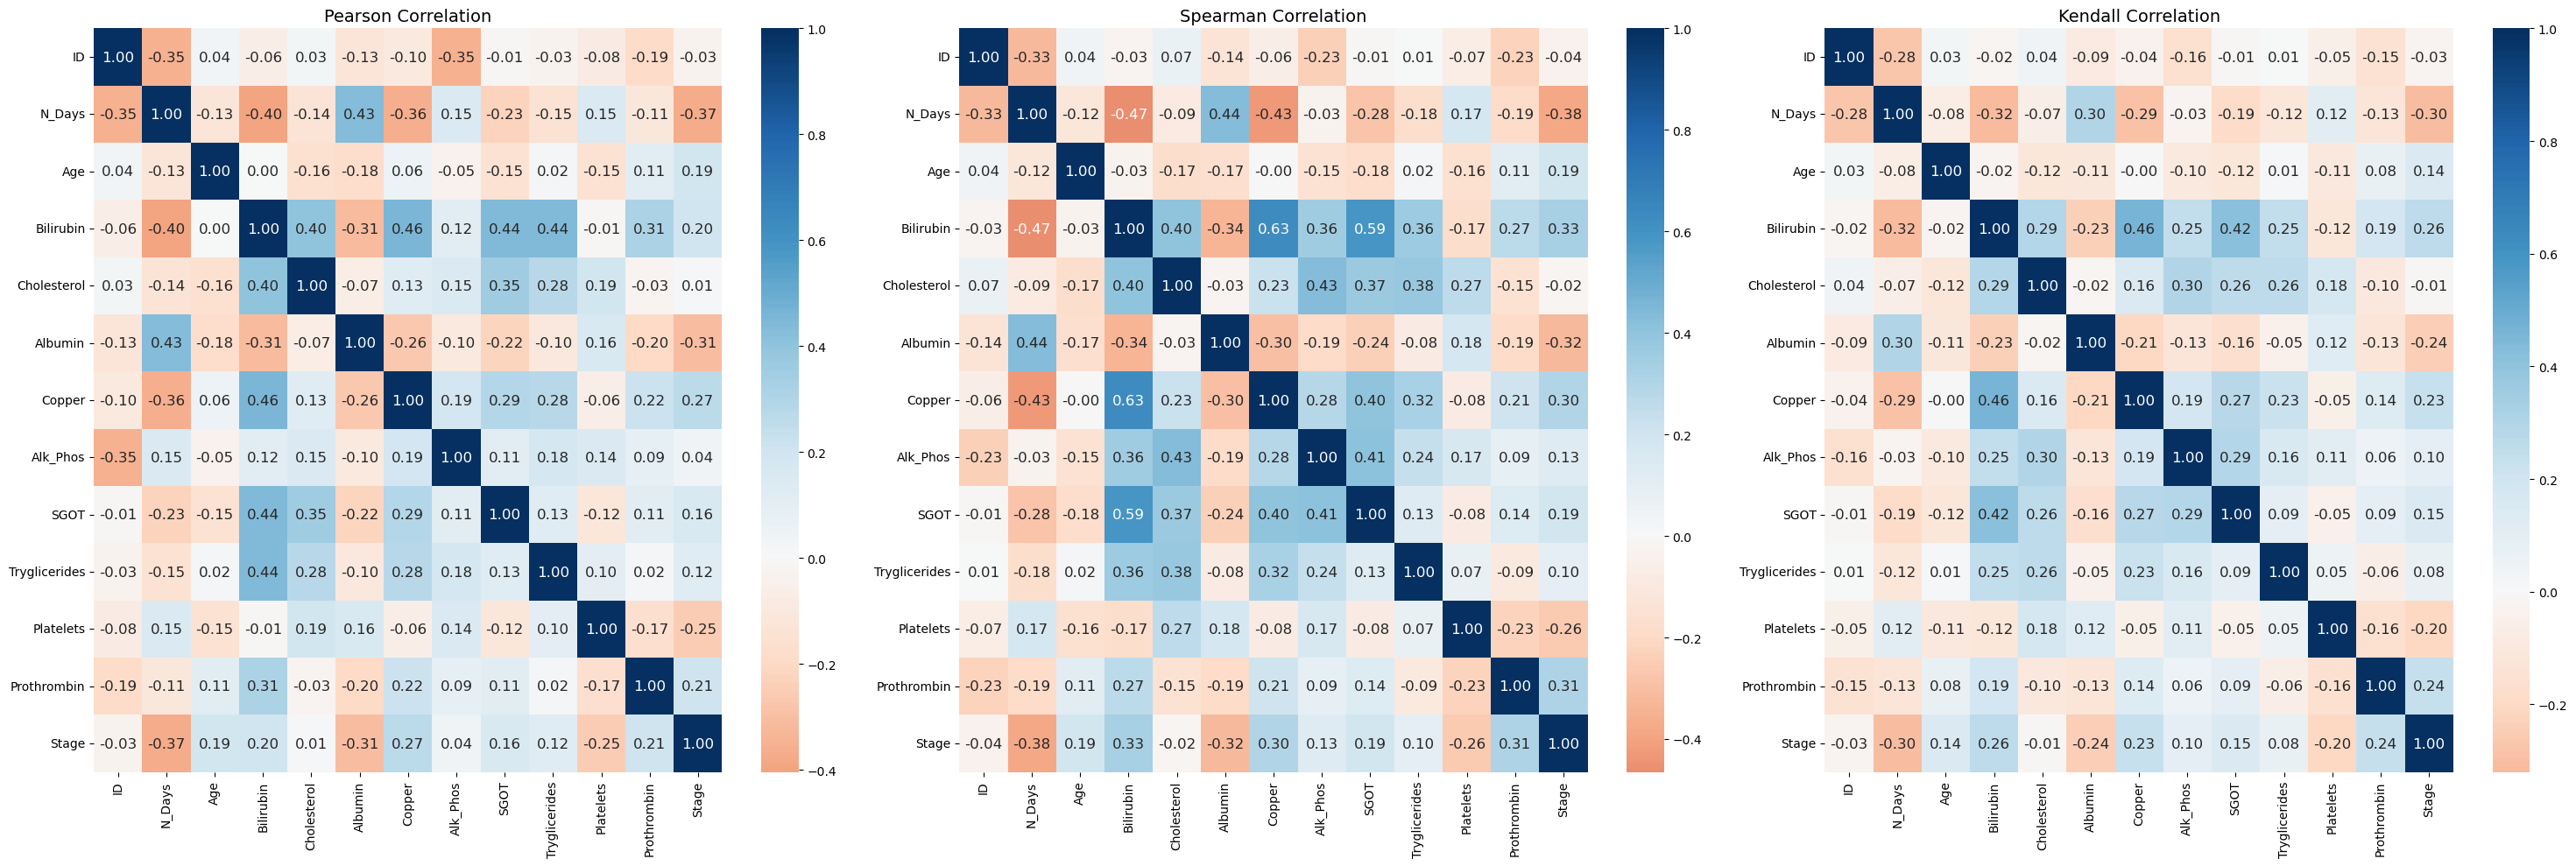

In [31]:
plot_correlation_heatmaps(correlations)

In [45]:
def cramers_v_matrix(df: pd.DataFrame, show_plot: bool = True):
    """
    Compute a pairwise Cramér’s V matrix for categorical and boolean columns.

    Parameters
    ----------
    df : DataFrame
        Input dataset; only categorical and boolean columns are used.
    show_plot : bool, default=True
        Whether to display a heatmap.

    Returns
    -------
    DataFrame
        Symmetric matrix of Cramér’s V values.
    """

    df_cat = df.select_dtypes(include=["object", "category", "bool"]).copy()

    cols = df_cat.columns
    V = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for a in cols:
        for b in cols:
            ct = pd.crosstab(df_cat[a], df_cat[b])
            if ct.shape[0] < 2 or ct.shape[1] < 2:
                V.loc[a, b] = np.nan
            else:
                chi2, _, _, _ = chi2_contingency(ct, correction=False)
                n = ct.values.sum()
                V.loc[a, b] = np.sqrt(chi2 / (n * (min(ct.shape) - 1)))

    print(f"Cramér’s V computed for {len(cols)} categorical features.")

    if show_plot and len(cols) > 1:
        plt.figure(figsize=(10, 8))
        sns.heatmap(V, annot=True, fmt=".2f", cmap="RdBu", center=0.5, linewidths=0.5)
        plt.title("Cramér’s V Association Heatmap", fontsize=14)
        plt.tight_layout()
        plt.show()

    return V


Cramér’s V computed for 4 categorical features.


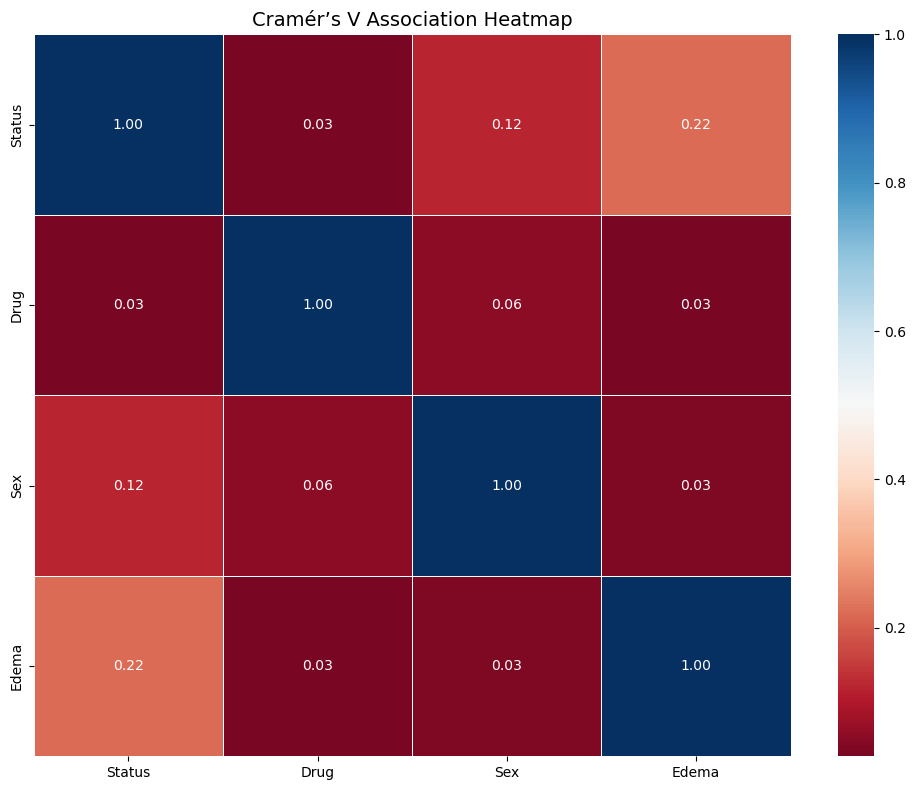

,Status,Drug,Sex,Edema
Status,1.000000,0.026866,0.118385,0.220057
Drug,0.026866,1.000000,0.055567,0.029029
Sex,0.118385,0.055567,1.000000,0.034779
Edema,0.220057,0.029029,0.034779,1.000000


In [47]:
cramers_v_matrix(df_cat)

In [38]:
def cat_vs_target_class(df, target_col):
    """
    Evaluate categorical features against a classification target using:
    - Cramér’s V (association strength)
    - Chi-square test (p-value)

    Returns a sorted DataFrame with both metrics.
    """

    target = df[target_col].astype("category")

    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns
    cat_cols = [c for c in cat_cols if c != target_col]

    results = []

    for col in cat_cols:
        ct = pd.crosstab(df[col], target)

        if ct.shape[0] < 2 or ct.shape[1] < 2:
            continue

        chi2, p, _, _ = chi2_contingency(ct, correction=False)

        n = ct.values.sum()
        r, k = ct.shape
        cramers_v = np.sqrt((chi2 / n) / (min(r, k) - 1))

        results.append({
            "feature": col,
            "cramers_v": cramers_v,
            "p_value": p
        })

    return (
        pd.DataFrame(results)
        .sort_values("cramers_v", ascending=False)
        .reset_index(drop=True)
    )


In [39]:
cat_vs_target_class(df_cat, target_col="Sex")

,feature,cramers_v,p_value
0,Status,0.118385,0.053443
1,Drug,0.055567,0.326340
2,Edema,0.034779,0.776619


In [41]:
def cat_vs_target_reg(df, target_col):
    """
    Compute ANOVA and Kruskal–Wallis p-values for categorical features
    against a numeric regression target. Returns both tests for each
    feature.

    Parameters
    ----------
    df : DataFrame
    target_col : str

    Returns
    -------
    DataFrame
        Categorical features with ANOVA and Kruskal p-values.
    """

    target = df[target_col]
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns

    results = []

    for col in cat_cols:
        groups = [target[df[col] == val].dropna()
            for val in df[col].dropna().unique()
        ]

        if len(groups) < 2:
            continue

        # ANOVA
        try:
            _, p_anova = f_oneway(*groups)
        except Exception:
            p_anova = float("nan")

        # Kruskal-Wallis
        try:
            _, p_kruskal = kruskal(*groups)
        except Exception:
            p_kruskal = float("nan")

        results.append({
            "feature": col,
            "p_anova": p_anova,
            "p_kruskal": p_kruskal,
            "unique_categories": df[col].nunique()
        })

    return (
        pd.DataFrame(results)
        .sort_values("p_anova")   
        .reset_index(drop=True)
    )


In [44]:
cat_vs_target_reg(df_clean2,'N_Days')

,feature,p_anova,p_kruskal,unique_categories
0,Status,1.076778e-07,8.694789e-08,3
1,Hepatomegaly,6.778386e-06,6.702084e-06,2
2,Edema,1.458088e-02,1.265522e-02,3
3,Spiders,1.680585e-02,1.616852e-02,2
4,Ascites,1.563471e-01,1.398789e-01,2
5,Drug,3.607863e-01,4.766796e-01,2
6,Sex,6.060641e-01,8.069844e-01,2


In [ ]:
def point_biserial_correlations(df: pd.DataFrame, target_col: str):
    """
    Compute point–biserial correlations between all numeric features and a
    binary classification target.

    Parameters
    ----------
    df : DataFrame
        Input dataset.
    target_col : str
        Name of the binary target column (0/1 or categorical).

    Returns
    -------
    DataFrame
        Table with each numeric feature and its point–biserial correlation
        coefficient and p-value, sorted by absolute correlation.
    """

    # convert target to binary codes if categorical
    target = df[target_col]
    if target.dtype == "object" or "category" in str(target.dtype):
        target = pd.Categorical(target).codes

    results = []
    for col in df.select_dtypes(include="number").columns:
        if col == target_col:
            continue

        x = df[col].fillna(df[col].median())
        corr, p = pointbiserialr(target, x)

        results.append({"feature": col, "correlation": corr, "p_value": p})

    return (
        pd.DataFrame(results)
        .sort_values("correlation", key=lambda s: s.abs(), ascending=False)
        .reset_index(drop=True)
    )


In [ ]:

import random

def select_features(df: pd.DataFrame,
                         feature_rank: pd.DataFrame,
                         top_frac: float = 0.7,
                         random_frac: float = 0.3,
                         seed: int = 42) -> pd.DataFrame:
    """
    Selects the initial feature set based on informativeness and diversity.

    Parameters
    ----------
    df : pd.DataFrame
        Original or preprocessed dataset.

    feature_rank : pd.DataFrame
        DataFrame containing features and their informativeness scores,
        must include columns ['feature', 'score'] sorted descending by score.

    top_frac : float, default=0.7
        Fraction of top informative features to include.

    random_frac : float, default=0.3
        Fraction of remaining lower-ranked features to randomly include
        to allow for new potential interactions.

    seed : int, default=42
        Random seed for reproducibility.

    """

    np.random.seed(seed)
    n = len(feature_rank)
    top_n = int(n * top_frac)
    rand_n = int((n - top_n) * random_frac)

    feats = (
        feature_rank['feature'].head(top_n).tolist() +
        np.random.choice(feature_rank['feature'].iloc[top_n:], rand_n, replace=False).tolist()
        if rand_n > 0 else feature_rank['feature'].head(top_n).tolist()
    )

    df_sel = df[feats].copy()

    df_sel = df_sel.loc[:, df_sel.apply(lambda s: s.nunique(dropna=False) > 1 and
                                        s.value_counts(normalize=True, dropna=False).iloc[0] <= 0.99)]

    df_sel = df_sel.loc[:, ~df_sel.T.duplicated()]

    print(f"Selected {df_sel.shape[1]} features.")
    return df_sel


In [ ]:
from itertools import combinations

def generate_new_features(df_num: pd.DataFrame, eps: float = 1e-6):
    """
    Generate new numeric features:
      - arithmetic (sum, diff, prod, ratio)
      - nonlinear (log, sqrt, square)
      - normalization (centered, scaled)
      - combined (log(x1*x2), x1/sqrt(x2))

    Parameters
    ----------
    df_num : pd.DataFrame
        DataFrame containing only numeric features.
    eps : float, default=1e-6
        Small constant to avoid division by zero.

    Returns
    -------
    pd.DataFrame
        DataFrame with original and newly generated features.
    """

    df_new = df_num.copy()

    for a, b in combinations(df_num.columns, 2):
        df_new[f"{a}_plus_{b}"] = df_num[a] + df_num[b]
        df_new[f"{a}_minus_{b}"] = df_num[a] - df_num[b]
        df_new[f"{a}_times_{b}"] = df_num[a] * df_num[b]
        df_new[f"{a}_div_{b}"] = df_num[a] / (df_num[b] + eps)

    for col in df_num.columns:
        df_new[f"log_{col}"] = np.log1p(np.abs(df_num[col]))  # log(x+1)
        df_new[f"sqrt_{col}"] = np.sqrt(np.abs(df_num[col]))
        df_new[f"square_{col}"] = np.square(df_num[col])

    for col in df_num.columns:
        mean = df_num[col].mean()
        std = df_num[col].std() + eps
        df_new[f"{col}_centered"] = df_num[col] - mean
        df_new[f"{col}_scaled"] = (df_num[col] - mean) / std

    for a, b in combinations(df_num.columns, 2):
        df_new[f"log_{a}_times_{b}"] = np.log1p(np.abs(df_num[a] * df_num[b]))
        df_new[f"{a}_div_sqrt_{b}"] = df_num[a] / (np.sqrt(np.abs(df_num[b])) + eps)

    df_new = df_new.replace([np.inf, -np.inf], np.nan)

    print(f"Generated {df_new.shape[1] - df_num.shape[1]} new features "
          f"(total: {df_new.shape[1]}).")

    return df_new


In [ ]:
def feature_target_relationship(df: pd.DataFrame, target_col: str, task: str):
    """
    Unified statistical framework for evaluating relationships between features and a target variable.

    Parameters
    ----------
    df : DataFrame
        Input dataset containing features and target.
    target_col : str
        Name of the target column.
    task : str
        'classification' or 'regression'.

    Returns
    -------
    dict
        {
        "categorical_vs_target": DataFrame,
        "numeric_vs_target": DataFrame
        }
    """

    target = df[target_col]

    numeric_feats = df.select_dtypes(include="number").columns.drop(target_col)
    categorical_feats = df.select_dtypes(include=["object", "category", "bool"]).columns

    results = {}


    if task == "classification":

        # --- categorical - target(cat) : Cramér’s V + χ² 
        cat_rows = []
        for col in categorical_feats:
            ct = pd.crosstab(df[col], target)
            if ct.shape[0] < 2 or ct.shape[1] < 2:
                continue

            chi2, p, *_ = chi2_contingency(ct, correction=False)

            # Cramer's V
            n = ct.values.sum()
            r, k = ct.shape
            cramers_v = np.sqrt(chi2 / (n * (min(r, k) - 1)))

            cat_rows.append({
                "feature": col,
                "cramers_v": cramers_v,
                "chi2_p": p
            })

        results["categorical_vs_target"] = pd.DataFrame(cat_rows)

        # numeric - target(cat) : point-biserial (binary only)
        num_rows = []
        if target.nunique() == 2:
            y = pd.Categorical(target).codes

            for col in numeric_feats:
                x = df[col].fillna(df[col].median())
                corr, p = pointbiserialr(y, x)

                num_rows.append({
                    "feature": col,
                    "point_biserial": corr,
                    "p_value": p
                })
        else:
            # multiclass targets(cat) - correlation ratio (eta)
            for col in numeric_feats:
                x = df[col].fillna(df[col].median())
                categories = target.values

                groups = [x[categories == t] for t in np.unique(categories)]
                grand_mean = x.mean()

                ss_between = sum([len(g) * (g.mean() - grand_mean)**2 for g in groups])
                ss_total = sum((x - grand_mean)**2)

                eta = np.sqrt(ss_between / ss_total) if ss_total > 0 else 0

                num_rows.append({
                    "feature": col,
                    "eta": eta
                })

        results["numeric_vs_target"] = pd.DataFrame(num_rows)


    elif task == "regression":

        # categorical - target(num) : ANOVA + Kruskal 
        cat_rows = []
        for col in categorical_feats:
            groups = [target[df[col] == c] for c in df[col].dropna().unique()]
            if len(groups) < 2:
                continue

            try: _, p_anova = f_oneway(*groups)
            except: p_anova = np.nan

            try: _, p_kruskal = kruskal(*groups)
            except: p_kruskal = np.nan

            cat_rows.append({
                "feature": col,
                "anova_p": p_anova,
                "kruskal_p": p_kruskal
            })

        results["categorical_vs_target"] = pd.DataFrame(cat_rows)

        # numeric - target(num) : Pearson + Spearman 
        num_rows = []
        for col in numeric_feats:
            x = df[col].fillna(df[col].median())

            pear, p_pear = pearsonr(x, target)
            spear, p_spear = spearmanr(x, target)

            num_rows.append({
                "feature": col,
                "pearson": pear,
                "pearson_p": p_pear,
                "spearman": spear,
                "spearman_p": p_spear
            })

        results["numeric_vs_target"] = pd.DataFrame(num_rows)

    else:
        raise ValueError("task must be either 'classification' or 'regression'")
    
    def _print_table(title, df_out):
        print("\n" + "="*60)
        print(title)
        print("="*60)

        if df_out is None or len(df_out) == 0:
            print("(no results)\n")
            return
        
        print(df_out.reset_index(drop=True).to_string(index=False))

    _print_table("CATEGORICAL VS TARGET", results["categorical_vs_target"])
    _print_table("NUMERIC VS TARGET", results["numeric_vs_target"])

    return results

In [66]:
results=feature_target_relationship(df_clean2, 'Bilirubin','regression' )


CATEGORICAL VS TARGET
     feature      anova_p    kruskal_p
      Status 6.271584e-09 2.425765e-11
        Drug 5.568914e-01 7.462489e-01
         Sex 8.908332e-01 1.290949e-01
     Ascites 2.250789e-02 2.757057e-01
Hepatomegaly 1.060753e-05 1.090945e-07
     Spiders 7.428282e-03 2.004811e-04
       Edema 1.071886e-02 9.634099e-02

NUMERIC VS TARGET
      feature   pearson    pearson_p  spearman   spearman_p
           ID -0.113193 1.678428e-01 -0.066380 4.196261e-01
       N_Days -0.425546 5.680354e-08 -0.474038 8.933914e-10
          Age  0.006167 9.402976e-01 -0.102849 2.104132e-01
  Cholesterol  0.333435 3.052391e-05  0.314394 8.923361e-05
      Albumin -0.273667 7.024726e-04 -0.352766 9.531792e-06
       Copper  0.445105 1.150072e-08  0.565061 4.977788e-14
     Alk_Phos  0.133086 1.044695e-01  0.390498 7.805383e-07
         SGOT  0.452054 6.361946e-09  0.486616 2.725418e-10
Tryglicerides  0.318424 7.153480e-05  0.241480 2.911235e-03
    Platelets -0.012758 8.768613e-01 -0.170899

In [85]:
def psi_1d(expected, actual, bins=10):
    """Simple 1D PSI calculation."""
    quantiles = np.linspace(0, 1, bins + 1)
    cuts = np.quantile(expected, quantiles)

    exp_counts = np.histogram(expected, bins=cuts)[0] / len(expected)
    act_counts = np.histogram(actual, bins=cuts)[0] / len(actual)

    exp_counts = np.where(exp_counts == 0, 1e-6, exp_counts)
    act_counts = np.where(act_counts == 0, 1e-6, act_counts)

    return np.sum((exp_counts - act_counts) * np.log(exp_counts / act_counts))


def js_distance_1d(p, q, bins=20):
    """Simple Jensen–Shannon distance."""
    hist_p, bin_edges = np.histogram(p, bins=bins, density=True)
    hist_q, _ = np.histogram(q, bins=bin_edges, density=True)

    hist_p = hist_p / hist_p.sum()
    hist_q = hist_q / hist_q.sum()

    hist_p = np.where(hist_p == 0, 1e-12, hist_p)
    hist_q = np.where(hist_q == 0, 1e-12, hist_q)

    m = 0.5 * (hist_p + hist_q)

    kl_pm = np.sum(hist_p * np.log(hist_p / m))
    kl_qm = np.sum(hist_q * np.log(hist_q / m))

    return np.sqrt(0.5 * (kl_pm + kl_qm))

In [93]:
def find_class_differences(df, target_col):
    """
    Визначає фічі, що добре відрізняють класи.
    Використовує:
        - point-biserial correlation для числових фіч (binary target)
        - Cramér's V для категоріальних фіч
    """

    target = df[target_col]
    numeric_cols = df.select_dtypes(include="number").columns
    numeric_cols = [c for c in numeric_cols if c != target_col]

    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns
    cat_cols = [c for c in cat_cols if c != target_col]

    rows = []

    if target.nunique() == 2:
        y = pd.Categorical(target).codes

        for col in numeric_cols:
            x = df[col].fillna(df[col].median())
            corr, _ = pointbiserialr(y, x)

            rows.append({
                "feature": col,
                "score": abs(corr),
                "method": "point-biserial",
                "type": "numeric"
            })

    for col in cat_cols:
        table = pd.crosstab(df[col], target)

        if table.shape[0] < 2 or table.shape[1] < 2:
            continue

        chi2, _, _, _ = chi2_contingency(table)
        total = table.values.sum()
        r, k = table.shape
        v = np.sqrt(chi2 / (total * (min(r, k) - 1)))

        rows.append({
            "feature": col,
            "score": v,
            "method": "Cramér's V",
            "type": "categorical"
        })

    result = pd.DataFrame(rows)
    result = result.sort_values("score", ascending=False).reset_index(drop=True)

    return result


In [94]:
find_class_differences(df_clean2, target_col='Hepatomegaly')

,feature,score,method,type
0,ID,0.608779,point-biserial,numeric
1,Status,0.479415,Cramér's V,categorical
2,Stage,0.381583,point-biserial,numeric
3,Spiders,0.360982,Cramér's V,categorical
4,Albumin,0.295857,point-biserial,numeric
5,Copper,0.279612,point-biserial,numeric
6,Bilirubin,0.236378,point-biserial,numeric
7,Edema,0.216276,Cramér's V,categorical
8,Cholesterol,0.203048,point-biserial,numeric
9,N_Days,0.188665,point-biserial,numeric


In [14]:
# ================================================
# Base utilities
# ================================================

def safe_div(x1, x2, eps=1e-6):
    return x1 / (x2 + eps)

def colname(*parts):
    return "_".join(str(p) for p in parts)

In [17]:
# Pairwise Arithmetic Interactions


def fe_interactions(df, cols, eps=1e-6):
    """
    Generates meaningful arithmetic interaction features.
    These combinations work best for RF/XGB/CatBoost.

    Generated:
      - x1 * x2
      - x1 / x2  (safe)
      - x2 / x1
      - x1 - x2
      - abs(x1 - x2)

    Args:
        df (pd.DataFrame): Input dataframe.
        cols (list): Selected top features (~10).
        eps (float): Epsilon for safe division.

    Returns:
        pd.DataFrame: Interaction features.
    """
    out = {}

    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            a, b = cols[i], cols[j]

            out[f"{a}_mul_{b}"] = df[a] * df[b]
            out[f"{a}_div_{b}"] = safe_div(df[a], df[b], eps)
            out[f"{b}_div_{a}"] = safe_div(df[b], df[a], eps)
            out[f"{a}_minus_{b}"] = df[a] - df[b]
            out[f"{b}_minus_{a}"] = df[b] - df[a]
            out[f"abs_{a}_minus_{b}"] = np.abs(df[a] - df[b])

    return pd.DataFrame(out)


# Non-linear Single-column transforms

def fe_non_linear(df, cols):
    """
    Generates non-linear transforms that add curvature to the model.
    Works extremely well for tree-based models.

    Generated:
      - log1p(x)
      - sqrt(x)
      - x^2
      - x^3 (often useful)
      - 1/x

    Args:
        df: Source dataframe.
        cols: Columns to transform.

    Returns:
        pd.DataFrame: Non-linear transformed features.
    """
    out = {}

    for c in cols:
        out[f"log1p_{c}"] = np.log1p(df[c].clip(lower=0))
        out[f"sqrt_{c}"] = np.sqrt(df[c].clip(lower=0))
        out[f"{c}_sq"] = df[c] ** 2
        out[f"{c}_cube"] = df[c] ** 3
        out[f"{c}_inv"] = 1.0 / (df[c] + 1e-6)

    return pd.DataFrame(out)

# Statistical transforms

def fe_stats(df, cols):
    """
    Generates statistical transforms useful for normalization-like effects.

    Generated:
      - z-score normalization
      - minmax normalization
      - centered value (x - mean)
      - standardized (x / std)

    Args:
        df: Dataframe
        cols: Selected feature columns

    Returns:
        pd.DataFrame: Statistical transformations
    """
    out = {}

    for c in cols:
        mean = df[c].mean()
        std = df[c].std() if df[c].std() != 0 else 1
        minv, maxv = df[c].min(), df[c].max()
        rng = maxv - minv if maxv != minv else 1

        out[f"{c}_centered"] = df[c] - mean
        out[f"{c}_z"] = (df[c] - mean) / std
        out[f"{c}_minmax"] = (df[c] - minv) / rng

    return pd.DataFrame(out)


# Depth-2 interaction transforms

def fe_depth2(df, cols):
    """
    High-impact depth-2 feature combinations.

    Generated:
      - log(x1 * x2 + 1)
      - sqrt(|x1 - x2|)
      - sqrt(x1 * x2)
      - x1 / sqrt(x2)
      - (x1 / x2) * x3   (3-way combinator)

    Args:
        df: DataFrame
        cols: Feature names (10–20 best)

    Returns:
        pd.DataFrame: depth-2 interaction features
    """
    out = {}

    # pairwise
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            a, b = df[cols[i]], df[cols[j]]
            an, bn = cols[i], cols[j]

            out[f"log_mul_{an}_{bn}"] = np.log1p(a * b)
            out[f"sqrt_absdiff_{an}_{bn}"] = np.sqrt(np.abs(a - b))
            out[f"sqrt_mul_{an}_{bn}"] = np.sqrt(np.clip(a * b, 0, None))
            out[f"{an}_div_sqrt_{bn}"] = a / (np.sqrt(b) + 1e-6)

    # triple-interaction: VERY powerful
    if len(cols) >= 3:
        for i in range(len(cols)):
            for j in range(i + 1, len(cols)):
                for k in range(j + 1, len(cols)):
                    a, b, c = cols[i], cols[j], cols[k]
                    out[f"{a}_div_{b}_mul_{c}"] = (
                        safe_div(df[a], df[b]) * df[c]
                    )

    return pd.DataFrame(out)


# feature generator

def generate_features(df, selected_cols):
    """
    Generates a curated set of genuinely high-impact ML features.
    This is optimized for 10 selected top features.

    Includes:
      - Pairwise arithmetic interactions
      - Non-linear per-column transforms
      - Statistical transforms
      - Depth-2 interaction transforms

    Args:
        df (pd.DataFrame): Input dataframe.
        selected_cols (list): Top-N selected features (default ~10).

    Returns:
        pd.DataFrame: All generated impact features combined.
    """
    return pd.concat([
        fe_interactions(df, selected_cols),
        fe_non_linear(df, selected_cols),
        fe_stats(df, selected_cols),
        fe_depth2(df, selected_cols)
    ], axis=1)


In [19]:
generate_features(df_clean2, selected_cols=['Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT',	'Tryglicerides'])

,Bilirubin_mul_Cholesterol,Bilirubin_div_Cholesterol,Cholesterol_div_Bilirubin,Bilirubin_minus_Cholesterol,Cholesterol_minus_Bilirubin,abs_Bilirubin_minus_Cholesterol,Bilirubin_mul_Albumin,Bilirubin_div_Albumin,Albumin_div_Bilirubin,Bilirubin_minus_Albumin,...,Albumin_div_Copper_mul_Alk_Phos,Albumin_div_Copper_mul_SGOT,Albumin_div_Copper_mul_Tryglicerides,Albumin_div_Alk_Phos_mul_SGOT,Albumin_div_Alk_Phos_mul_Tryglicerides,Albumin_div_SGOT_mul_Tryglicerides,Copper_div_Alk_Phos_mul_SGOT,Copper_div_Alk_Phos_mul_Tryglicerides,Copper_div_SGOT_mul_Tryglicerides,Alk_Phos_div_SGOT_mul_Tryglicerides
0,240.0,0.002667,374.999531,-299.2,299.2,299.2,2.352,0.272109,3.674995,-2.14,...,22.832727,1.657091,1.260000,0.213371,0.162241,2.235484,16.764883,12.747492,175.645160,1364.101372
1,NaN,NaN,NaN,NaN,NaN,NaN,9.039,0.585242,1.708695,-1.63,...,299.334988,21.827874,NaN,0.286580,NaN,NaN,1.750109,NaN,NaN,NaN
2,179.4,0.002007,498.332503,-298.4,298.4,298.4,2.016,0.178571,5.599991,-2.76,...,404.514765,32.153738,12.417391,0.267077,0.103142,1.297592,1.828205,0.706031,8.882326,1069.354834
3,534.0,0.007491,133.499933,-265.0,265.0,265.0,7.340,0.544959,1.834999,-1.67,...,31.091910,8.117298,3.711236,0.958143,0.438064,1.677927,23.235610,10.623342,40.690881,344.729488
4,NaN,NaN,NaN,NaN,NaN,NaN,3.839,0.315186,3.172724,-2.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,403.2,0.014286,69.999971,-165.6,165.6,165.6,6.144,0.937500,1.066666,-0.16,...,12.014933,1.375573,0.853333,0.293091,0.181818,1.588089,25.759943,15.980114,139.578163,655.086843
146,986.7,0.011037,90.606033,-295.7,295.7,295.7,11.715,0.929577,1.075757,-0.25,...,27.885114,3.234294,1.354962,0.411752,0.172498,1.487222,15.194218,6.365403,54.880603,431.085040
147,NaN,NaN,NaN,NaN,NaN,NaN,28.390,2.544909,0.392941,5.16,...,29.624348,3.762168,NaN,0.424166,NaN,NaN,20.446324,NaN,NaN,NaN
148,8000.0,0.003125,319.999936,-1595.0,1595.0,1595.0,16.050,1.557632,0.642000,1.79,...,113.676798,3.516020,7.447200,0.099285,0.210294,6.799026,2.319748,4.913404,158.855750,5625.611617


In [ ]:
def compute_feature_overlap(
    df: pd.DataFrame,
    top_k: int = 3,
    use_pearson: bool = False,
    use_kendall: bool = False,
    return_pairwise: bool = True
):
    """
    Compute feature overlap scores.

    Overlap definition:
      - numeric + numeric - |Spearman| (Pearson / Kendall optional)
      - categorical + categorical - Cramér’s V
      - numeric + categorical - Correlation Ratio (η²)

    How to interpret results:
      - overlap_score ∈ [0, 1]
      - lower overlap_score - feature is more unique (better)
      - higher overlap_score - feature is redundant (duplicates other features)
      - overlap_score is computed as mean of top-k strongest overlaps per feature

    Parameters
    ----------
    df : pd.DataFrame
        Dataset with features only (no target).
    top_k : int, default=3
        Number of strongest overlaps used to aggregate feature score.
    use_pearson : bool, default=False
        Whether to include Pearson correlation for numeric-numeric pairs.
    use_kendall : bool, default=False
        Whether to include Kendall tau for numeric-numeric pairs.
    return_pairwise : bool, default=True
        Whether to return pairwise overlap table.

    Returns
    -------
    dict
        {
          "feature_overlap": pd.DataFrame,
          "pairwise_overlap": pd.DataFrame | None
        }
    """

    # ---------- helper functions ----------

    def cramers_v(x, y):

        table = pd.crosstab(x, y)
        if table.shape[0] < 2 or table.shape[1] < 2:
            return 0.0

        chi2 = chi2_contingency(table, correction=False)[0]

        n = table.values.sum()
        k = min(table.shape)
        v = np.sqrt(chi2 / (n * (k - 1)))

        return v


    def correlation_ratio(categories, values):

        categories = pd.Categorical(categories)
        values = np.asarray(values, dtype=float)

        overall_mean = np.nanmean(values)

        explained_variance = 0.0

        for category in categories.categories:
            group_values = values[categories == category]

            if len(group_values) == 0:
                continue

            group_mean = np.nanmean(group_values)
            explained_variance += len(group_values) * (group_mean - overall_mean) ** 2

        total_variance = np.nansum((values - overall_mean) ** 2)

        if total_variance == 0:
            return 0.0

        return explained_variance / total_variance


    # pairwise overlap 

    features = df.columns
    rows = []

    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            f1 = features[i]
            f2 = features[j]

            x = df[f1]
            y = df[f2]

            x_is_num = pd.api.types.is_numeric_dtype(x)
            y_is_num = pd.api.types.is_numeric_dtype(y)

            if x_is_num and y_is_num:
                overlap = abs(spearmanr(x, y, nan_policy="omit")[0])

                if use_pearson:
                    overlap = max(overlap, abs(pearsonr(x, y)[0]))

                if use_kendall:
                    overlap = max(overlap, abs(kendalltau(x, y)[0]))

                pair_type = "numeric-numeric"

            elif not x_is_num and not y_is_num:
                overlap = cramers_v(x, y)
                pair_type = "categorical-categorical"

            else:
                if x_is_num:
                    overlap = correlation_ratio(y, x)
                else:
                    overlap = correlation_ratio(x, y)

                pair_type = "numeric-categorical"

            rows.append({
            "feature_a": f1,
            "feature_b": f2,
            "type_pair": pair_type,
            "overlap_score": overlap
        })

    pairwise_df = pd.DataFrame(rows)



    feature_rows = []

    for feature in features:

        scores_as_a = pairwise_df.loc[
            pairwise_df["feature_a"] == feature, "overlap_score"
        ]

        scores_as_b = pairwise_df.loc[
            pairwise_df["feature_b"] == feature, "overlap_score"
        ]

        all_scores = pd.concat([scores_as_a, scores_as_b])

        strongest_scores = all_scores.sort_values(ascending=False).head(top_k)

        # agg into single feature overlap score
        if len(strongest_scores) == 0:
            overlap_score = 0.0
        else:
            overlap_score = strongest_scores.mean()

        feature_rows.append({
            "feature": feature,
            "overlap_score": overlap_score
        })

    # feature-level table
    feature_df = pd.DataFrame(feature_rows)
    feature_df = feature_df.sort_values("overlap_score", ascending=True)
    feature_df = feature_df.reset_index(drop=True)

    return {
        "feature_overlap": feature_df,
        "pairwise_overlap": pairwise_df if return_pairwise else None
    }



In [13]:
r= compute_feature_overlap(df_clean2)
r["feature_overlap"]

,feature,overlap_score
0,Sex,0.103396
1,Drug,0.126347
2,Age,0.210832
3,Platelets,0.235323
4,ID,0.244300
5,Tryglicerides,0.265918
6,Prothrombin,0.285634
7,Spiders,0.339727
8,Status,0.343871
9,Ascites,0.356784


In [14]:
r['pairwise_overlap']

,feature_a,feature_b,type_pair,overlap_score
0,ID,N_Days,numeric-numeric,0.220663
1,ID,Status,numeric-categorical,0.117792
2,ID,Drug,numeric-categorical,0.112011
3,ID,Age,numeric-numeric,0.032021
4,ID,Sex,numeric-categorical,0.019617
...,...,...,...,...
185,Tryglicerides,Prothrombin,numeric-numeric,0.076114
186,Tryglicerides,Stage,numeric-numeric,0.126641
187,Platelets,Prothrombin,numeric-numeric,0.175148
188,Platelets,Stage,numeric-numeric,0.228324


In [15]:
compute_feature_overlap(df_clean2)

{'feature_overlap':           feature  overlap_score
 0             Sex       0.103396
 1            Drug       0.126347
 2             Age       0.210832
 3       Platelets       0.235323
 4              ID       0.244300
 5   Tryglicerides       0.265918
 6     Prothrombin       0.285634
 7         Spiders       0.339727
 8          Status       0.343871
 9         Ascites       0.356784
 10   Hepatomegaly       0.358360
 11        Albumin       0.359439
 12    Cholesterol       0.373196
 13          Stage       0.385654
 14          Edema       0.414152
 15       Alk_Phos       0.417191
 16         N_Days       0.445558
 17           SGOT       0.446937
 18         Copper       0.475012
 19      Bilirubin       0.555562,
 'pairwise_overlap':          feature_a    feature_b            type_pair  overlap_score
 0               ID       N_Days      numeric-numeric       0.220663
 1               ID       Status  numeric-categorical       0.117792
 2               ID         Drug  numer

In [16]:

# ---------- helper functions ----------

def cramers_v(x, y):

        table = pd.crosstab(x, y)
        if table.shape[0] < 2 or table.shape[1] < 2:
            return 0.0

        chi2 = chi2_contingency(table, correction=False)[0]

        n = table.values.sum()
        k = min(table.shape)
        v = np.sqrt(chi2 / (n * (k - 1)))

        return v


def correlation_ratio(categories, values):

        categories = pd.Categorical(categories)
        values = np.asarray(values, dtype=float)

        overall_mean = np.nanmean(values)

        explained_variance = 0.0

        for category in categories.categories:
            group_values = values[categories == category]

            if len(group_values) == 0:
                continue

            group_mean = np.nanmean(group_values)
            explained_variance += len(group_values) * (group_mean - overall_mean) ** 2

        total_variance = np.nansum((values - overall_mean) ** 2)

        if total_variance == 0:
            return 0.0

        return explained_variance / total_variance

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, chi2_contingency
from pandas.api.types import is_numeric_dtype


def compute_separability(
    X: pd.DataFrame,
    y: pd.Series,
    run_permutation: bool = True,
    n_permutations: int = 300
):
    """
    Simple separability + permutation test.
    """

    # helpers 

    def cramers_v(x, y):
        table = pd.crosstab(x, y)
        if table.shape[0] < 2 or table.shape[1] < 2:
            return 0.0
        chi2 = chi2_contingency(table, correction=False)[0]
        n = table.values.sum()
        k = min(table.shape)
        return np.sqrt(chi2 / (n * (k - 1)))

    def correlation_ratio(categories, values):
        categories = pd.Categorical(categories)
        values = np.asarray(values, dtype=float)

        mean_total = np.nanmean(values)
        ss_between = 0.0

        for cat in categories.categories:
            group = values[categories == cat]
            if len(group) == 0:
                continue
            ss_between += len(group) * (np.nanmean(group) - mean_total) ** 2

        ss_total = np.nansum((values - mean_total) ** 2)
        return ss_between / ss_total if ss_total > 0 else 0.0

    def separability_single_feature(x, y):
        x_is_num = is_numeric_dtype(x)
        y_is_num = is_numeric_dtype(y)

        if y_is_num:
            if x_is_num:
                return abs(spearmanr(x, y, nan_policy="omit")[0])
            else:
                return correlation_ratio(x, y)
        else:
            if x_is_num:
                return correlation_ratio(y, x)
            else:
                return cramers_v(x, y)

    # main separability 

    rows = []

    for feature in X.columns:
        x = X[feature]
        score = separability_single_feature(x, y)

        rows.append({
            "feature": feature,
            "separability_score": score
        })

    df = pd.DataFrame(rows).sort_values(
        "separability_score", ascending=False
    ).reset_index(drop=True)

    # permutation test 

    if run_permutation:
        p_values = []

        for feature in df["feature"]:
            x = X[feature]
            observed = df.loc[df["feature"] == feature, "separability_score"].iloc[0]
            perm_scores = []

            for i in range(n_permutations):
                y_perm = np.random.permutation(y)
                perm_scores.append(separability_single_feature(x, y_perm))

            perm_scores = np.array(perm_scores)
            p_values.append(np.mean(perm_scores >= observed))

        df["perm_p_value"] = p_values

    return df


In [28]:
d2=df_clean1['Age']
separability_df = compute_separability(df_clean1,d2)
separability_df


,feature,separability_score,perm_p_value
0,Age,1.000000,0.000000
1,Stage,0.189401,0.000000
2,SGOT,0.182614,0.003333
3,Cholesterol,0.172545,0.003333
4,Albumin,0.166049,0.000000
5,Platelets,0.156162,0.006667
6,Alk_Phos,0.145766,0.016667
7,N_Days,0.120460,0.010000
8,Prothrombin,0.112490,0.020000
9,Status,0.088450,0.000000


In [32]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, kruskal, chi2_contingency
from pandas.api.types import is_numeric_dtype


def compute_impact_all_features(X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    """
    Compute statistical impact (effect size) of each feature on the target.
    """

    results = []

    for feature in X.columns:
        x = X[feature]

        x_is_num = is_numeric_dtype(x)
        y_is_num = is_numeric_dtype(y)

        # -------- numeric + numeric --------
        if x_is_num and y_is_num:
            corr, p = spearmanr(x, y, nan_policy="omit")

            impact = abs(corr)
            metric = "spearman"
            test = "spearman"

        # -------- numeric + categorical --------
        elif x_is_num and not y_is_num:
            categories = pd.Categorical(y)
            values = x.astype(float)

            mean_total = values.mean()
            ss_between = 0.0

            for cat in categories.categories:
                group = values[y == cat]
                ss_between += len(group) * (group.mean() - mean_total) ** 2

            ss_total = ((values - mean_total) ** 2).sum()
            impact = ss_between / ss_total if ss_total > 0 else 0.0

            groups = [x[y == cat] for cat in categories.categories]
            _, p = kruskal(*groups)

            metric = "eta_squared"
            test = "kruskal"

        # -------- categorical + numeric --------
        elif not x_is_num and y_is_num:
            categories = pd.Categorical(x)
            values = y.astype(float)

            mean_total = values.mean()
            ss_between = 0.0

            for cat in categories.categories:
                group = values[x == cat]
                ss_between += len(group) * (group.mean() - mean_total) ** 2

            ss_total = ((values - mean_total) ** 2).sum()
            impact = ss_between / ss_total if ss_total > 0 else 0.0

            groups = [y[x == cat] for cat in categories.categories]
            _, p = kruskal(*groups)

            metric = "eta_squared"
            test = "kruskal"

        # -------- categorical + categorical --------
        else:
            table = pd.crosstab(x, y)

            if table.shape[0] < 2 or table.shape[1] < 2:
                impact = 0.0
                p = np.nan
            else:
                chi2, p, _, _ = chi2_contingency(table)
                n = table.values.sum()
                k = min(table.shape)
                impact = np.sqrt(chi2 / (n * (k - 1)))

            metric = "cramers_v"
            test = "chi2"

        results.append({
            "feature": feature,
            "impact_score": impact,
            "impact_metric": metric,
            "test": test,
            "p_value": p
        })

    return (
        pd.DataFrame(results)
        .sort_values("impact_score", ascending=False)
        .reset_index(drop=True)
    )


In [33]:
impact_df = compute_impact_all_features(X=df_clean1, y=df_clean1["Cholesterol"])
impact_df


,feature,impact_score,impact_metric,test,p_value
0,Cholesterol,1.000000,spearman,spearman,0.000000e+00
1,Alk_Phos,0.432986,spearman,spearman,2.091189e-14
2,Bilirubin,0.402454,spearman,spearman,1.753058e-12
3,Tryglicerides,0.379729,spearman,spearman,4.190973e-11
4,SGOT,0.372697,spearman,spearman,8.677796e-11
5,Platelets,0.265973,spearman,spearman,6.415450e-06
6,Copper,0.225713,spearman,spearman,1.318519e-04
7,Age,0.172545,spearman,spearman,3.535777e-03
8,Prothrombin,0.153252,spearman,spearman,9.694005e-03
9,N_Days,0.088546,spearman,spearman,1.366085e-01


In [34]:
def compute_feature_quality(
    X: pd.DataFrame,
    y: pd.Series,
    weights=None,
    top_k_overlap: int = 3
):
    if weights is None:
        weights = {
            "separability": 1.0,
            "impact": 1.0,
            "overlap": 1.0
        }

    # 1. overlap (mean of top-k strongest overlaps)
    overlap_df = compute_feature_overlap(
        df=X,
        top_k=top_k_overlap,
        return_pairwise=False
    )["feature_overlap"]

    # 2. separability
    separability_df = compute_separability(X, y)

    # 3. impact
    impact_df = compute_impact_all_features(X, y)

    # 4. merge everything
    df = (
        overlap_df
        .merge(separability_df, on="feature")
        .merge(impact_df, on="feature")
    )

    # 5. final score
    df["final_score"] = (
        df["separability_score"] ** weights["separability"]
        * df["impact_score"] ** weights["impact"]
        * (1 - df["overlap_score"]) ** weights["overlap"]
    )

    return df.sort_values("final_score", ascending=False).reset_index(drop=True)


In [36]:
quality_df = compute_feature_quality(
    df_clean1, df_clean1['Albumin'],
    weights={
        "separability": 1.0,
        "impact": 2.0,
        "overlap": 1.0
    }
)


In [37]:
quality_df

,feature,overlap_score,separability_score,perm_p_value,impact_score,impact_metric,test,p_value,final_score
0,Albumin,0.364142,1.000000,0.000000,1.000000,spearman,spearman,0.000000e+00,6.358577e-01
1,N_Days,0.444350,0.438674,0.000000,0.438674,spearman,spearman,4.352088e-21,4.690575e-02
2,Stage,0.344983,0.317082,0.000000,0.317082,spearman,spearman,4.480681e-11,2.088172e-02
3,Bilirubin,0.559959,0.336671,0.000000,0.336671,spearman,spearman,1.548277e-12,1.679237e-02
4,Copper,0.487344,0.298269,0.000000,0.298269,spearman,spearman,8.666268e-08,1.360346e-02
5,SGOT,0.466080,0.236190,0.000000,0.236190,spearman,spearman,2.497924e-05,7.034941e-03
6,Prothrombin,0.269148,0.187587,0.000000,0.187587,spearman,spearman,1.187252e-04,4.824331e-03
7,Platelets,0.250844,0.178427,0.000000,0.178427,spearman,spearman,2.973025e-04,4.255566e-03
8,Alk_Phos,0.399373,0.185430,0.000000,0.185430,spearman,spearman,9.990801e-04,3.829524e-03
9,Age,0.181520,0.166049,0.000000,0.166049,spearman,spearman,6.534153e-04,3.747319e-03


In [40]:
def generate_feature_combinations(
    df: pd.DataFrame,
    max_pairs: int = 50,
    epsilon: float = 1e-6,
    random_state: int = 42
) -> pd.DataFrame:

    np.random.seed(random_state)

    df_base = df.copy()
    new_features = {}  # <-- ключовий момент

    num_features = [c for c in df.columns if is_numeric_dtype(df[c])]

    # ---------- unary ----------
    for col in num_features:
        x = df[col]

        new_features[f"log_{col}"] = np.log(x + 1)
        new_features[f"sqrt_{col}"] = np.sqrt(np.clip(x, 0, None))
        new_features[f"{col}_sq"] = x ** 2
        new_features[f"{col}_scaled"] = x / (x.std() + epsilon)
        new_features[f"{col}_rank"] = x.rank(pct=True)
        new_features[f"{col}_dev_median"] = (x - x.median()).abs()

    # ---------- binary ----------
    all_pairs = list(combinations(num_features, 2))
    np.random.shuffle(all_pairs)

    for a, b in all_pairs[:max_pairs]:
        x1, x2 = df[a], df[b]

        new_features[f"{a}_mul_{b}"] = x1 * x2
        new_features[f"{a}_div_{b}"] = x1 / (x2 + epsilon)
        new_features[f"abs_{a}_minus_{b}"] = (x1 - x2).abs()
        new_features[f"log_{a}_mul_{b}"] = np.log(x1 * x2 + 1)
        new_features[f"{a}_div_sqrt_{b}"] = x1 / (np.sqrt(np.clip(x2, 0, None)) + epsilon)

    # ---------- one concat ----------
    df_new = pd.concat([df_base, pd.DataFrame(new_features)], axis=1)

    return df_new


In [41]:
res=generate_feature_combinations(df_clean1)

In [42]:
res

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,...,Alk_Phos_mul_Tryglicerides,Alk_Phos_div_Tryglicerides,abs_Alk_Phos_minus_Tryglicerides,log_Alk_Phos_mul_Tryglicerides,Alk_Phos_div_sqrt_Tryglicerides,Cholesterol_mul_Tryglicerides,Cholesterol_div_Tryglicerides,abs_Cholesterol_minus_Tryglicerides,log_Cholesterol_mul_Tryglicerides,Cholesterol_div_sqrt_Tryglicerides
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,...,295496.0,9.988372,1546.0,12.596414,130.996262,44892.0,1.517442,89.0,10.712037,19.901062
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,...,650742.4,84.031817,7306.8,13.385871,788.288245,26576.0,3.431818,214.0,10.187801,32.193305
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,...,28380.0,9.381818,461.0,10.253475,69.577416,9680.0,3.200000,121.0,9.177920,23.731832
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,...,563205.6,66.541304,6029.8,13.241402,638.241703,22448.0,2.652174,152.0,10.019001,25.438756
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,...,48312.0,9.319444,599.0,10.785456,79.078099,20088.0,3.875000,207.0,9.907928,32.880461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,D,NaN,24472,F,NaN,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
414,415,1103,C,NaN,14245,F,NaN,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415,416,1055,C,NaN,20819,F,NaN,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
416,417,691,C,NaN,21185,F,NaN,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
quality_df = compute_feature_quality(
    res, df_clean1['Albumin'],
    weights={
        "separability": 1.0,
        "impact": 2.0,
        "overlap": 1.0
    }
)

In [46]:
display(quality_df)

,feature,overlap_score,separability_score,perm_p_value,impact_score,impact_metric,test,p_value,final_score
0,log_Albumin_mul_Prothrombin,0.842391,0.763587,0.0,0.763587,spearman,spearman,1.158288e-80,7.017070e-02
1,Albumin_mul_Prothrombin,0.842392,0.763588,0.0,0.763588,spearman,spearman,1.157134e-80,7.017067e-02
2,Albumin_div_Prothrombin,0.910634,0.856689,0.0,0.856689,spearman,spearman,4.354330e-121,5.618774e-02
3,Albumin_div_sqrt_Prothrombin,0.955794,0.946398,0.0,0.946398,spearman,spearman,2.685690e-205,3.747189e-02
4,Albumin_div_sqrt_Stage,0.904906,0.720335,0.0,0.720335,spearman,spearman,3.965752e-67,3.554315e-02
...,...,...,...,...,...,...,...,...,...
343,Copper,1.000000,0.298269,0.0,0.298269,spearman,spearman,8.666268e-08,-5.892012e-18
344,Copper_scaled,1.000000,0.298269,0.0,0.298269,spearman,spearman,8.666268e-08,-5.892012e-18
345,Copper_rank,1.000000,0.298269,0.0,0.298269,spearman,spearman,8.666268e-08,-5.892012e-18
346,sqrt_Copper,1.000000,0.298269,0.0,0.298269,spearman,spearman,8.666268e-08,-5.892012e-18


In [47]:
from itertools import combinations
from pandas.api.types import is_numeric_dtype
import numpy as np
import pandas as pd


def generate_custom_feature_combinations(
    df: pd.DataFrame,
    unary_ops: dict[str, callable] | None = None,
    binary_ops: dict[str, callable] | None = None,
    max_pairs: int = 50,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Generate new features using user-defined operations.

    unary_ops:  {name: f(x)}
    binary_ops: {name: f(x1, x2)}
    """

    np.random.seed(random_state)

    df_base = df.copy()
    new_features = {}

    num_features = [c for c in df.columns if is_numeric_dtype(df[c])]

    # ---------- unary ----------
    if unary_ops:
        for col in num_features:
            x = df[col]
            for name, func in unary_ops.items():
                try:
                    new_features[f"{name}_{col}"] = func(x)
                except Exception:
                    continue  # safe skip

    # ---------- binary ----------
    if binary_ops:
        pairs = list(combinations(num_features, 2))
        np.random.shuffle(pairs)

        for a, b in pairs[:max_pairs]:
            x1, x2 = df[a], df[b]
            for name, func in binary_ops.items():
                try:
                    new_features[f"{a}_{name}_{b}"] = func(x1, x2)
                except Exception:
                    continue

    return pd.concat([df_base, pd.DataFrame(new_features)], axis=1)
